# 画像識別AIをつくろう（CNN編）


手書き数字の画像のデータセットMNISTを使用して、画像から数字を推論する機械学習モデルを作ります。

### 手順

1. 環境構築
1. データセットのダウンロードと変換
1. データローダーの作成
1. 機械学習モデルの実装
1. 学習
1. 評価

## 1.環境構築

In [37]:
# PytorchとPytorchVisionをインポート
# Pytorch: https://pytorch.org
# PytorchVision: https://pytorch.org/vision/stable/index.html

import torch
import torchvision

In [38]:
# Google Colabの場合、右上のランタイムの設定で「T4」を選択
# PytorchのコマンドでGPUが利用可能かを確認
# ColabのGPU詳細: https://mccormickml.com/2024/04/23/colab-gpus-features-and-pricing/

torch.cuda.is_available()

True

In [39]:
# NumpyとMatplotlibをインポート
# Numpy: https://numpy.org/
# Matplotlib: https://matplotlib.org/

import numpy as np
import matplotlib.pyplot as plt

## 2. データセットのダウンロードと変換

手書き数字のデータセットである [MNIST] をダウンロードし、学習しやすいように変換する 

[MNIST]: https://en.wikipedia.org/wiki/MNIST_database

In [40]:
# 2-1. データセットのダウンロード

train_dataset = torchvision.datasets.MNIST("./data", train=True, download=True)
test_dataset = torchvision.datasets.MNIST("./data", train=False, download=True)

60000 10000
<class 'PIL.Image.Image'> <class 'int'>


((28, 28), 5)

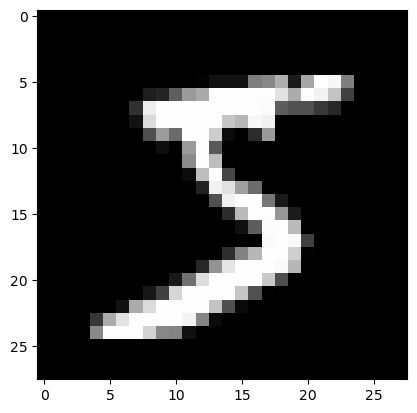

In [41]:
# 2-2. データセットの確認

print(len(train_dataset), len(test_dataset))
print(type(train_dataset[0][0]), type(train_dataset[0][1]))
plt.imshow(train_dataset[0][0], cmap="gray")
train_dataset[0][0].size, train_dataset[0][1]

# データ数は訓練データが 60,000、テストデータが 10,000 ある
# 入力は 28 x 28 の PIL 画像、出力はラベル
# PIL Image モジュール: https://pillow.readthedocs.io/en/stable/reference/Image.html

In [42]:
# 2-3. データセットの統計の確認

train_max = train_dataset.data.max().float().item()
train_min = train_dataset.data.min().float().item()
print("訓練データの最大値:", train_max, "最小値:", train_min)

train_scaled_mean = (train_dataset.data.float().mean() / train_max).item()
train_scaled_std = (train_dataset.data.float().std() / train_max).item()
print("訓練データの平均値:", train_scaled_mean, "標準偏差:", train_scaled_std)

test_max = test_dataset.data.max().float().item()
test_min = test_dataset.data.min().float().item()
print("テストデータの最大値:", test_max, "最小値:", test_min)

test_scaled_mean = (test_dataset.data.float().mean() / test_max).item()
test_scaled_std = (test_dataset.data.float().std() / test_max).item()
print("テストデータの平均値:", test_scaled_mean, "標準偏差:", test_scaled_std)

訓練データの最大値: 255.0 最小値: 0.0
訓練データの平均値: 0.13066047430038452 標準偏差: 0.30810779333114624
テストデータの最大値: 255.0 最小値: 0.0
テストデータの平均値: 0.1325145959854126 標準偏差: 0.3104802668094635


In [43]:
# 2-4. データセットの変換
# PIL画像をテンソル（torch.Tensor）に変換し、 正規化する
# 正規化の計算式: output = (input - mean) / std

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((train_scaled_mean,), (train_scaled_std,))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((test_scaled_mean,), (test_scaled_std,))
])

train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=train_transform)
test_dataset = torchvision.datasets.MNIST("./data", train=False, transform=test_transform)

In [44]:
# 2-5. 変換後のデータの確認
# 最初の画像を数字で表示してみる

x = train_dataset[0][0]

print("テンソルの形", x.shape)
print("最小値", x.min().item())
print("最大値", x.max().item())
print("平均", x.mean().item())
print("標準偏差", x.std().item())
x

テンソルの形 torch.Size([1, 28, 28])
最小値 -0.4240739047527313
最大値 2.8215434551239014
平均 0.022782936692237854
標準偏差 1.014410376548767


tensor([[[-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
          -0.4241, -0.4241, -0.4241, -0.4241, -0

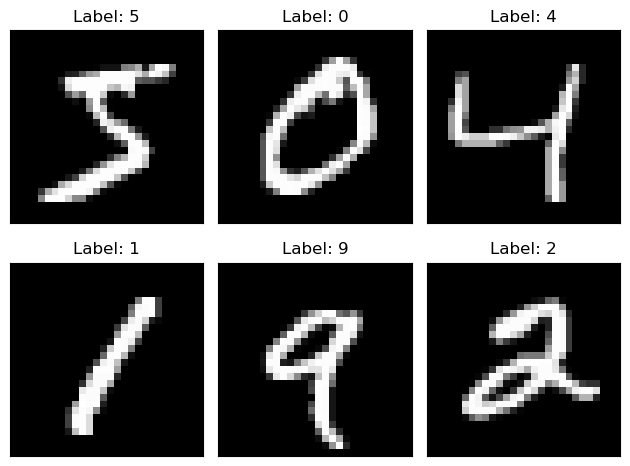

In [45]:
# 訓練データの画像を試しに表示してみる

for i in range(6):
    # 2行3列のグリッドのi+1番目を描画
    plt.subplot(2, 3, i + 1)
    # 画像のテンソルを取得
    image_tensor = train_dataset[i][0]
    image_tensor = image_tensor * train_scaled_std + train_scaled_mean
    # (チャンネル, 縦, 横) -> (縦, 横, チャンネル)
    permuted = image_tensor.permute(1, 2, 0)

    plt.title(f"Label: {train_dataset[i][1]}")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

    plt.imshow(permuted, cmap="gray")

# 2.データーローダーの作成

学習時にサンプルをバッチに分けて処理するため、データローダーにデータセットを読み込ませる

In [46]:
# 60,000 の訓練データを 64 ずつのバッチに分ける
# shuffle は一定ごとに（エポックごとに）データをシャッフルする
# バッチのサイズは大きいほど学習が安定するが、メモリを多く消費する
# DataLoader: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 10,000 のテストデータを 1000 ずつのバッチに分ける
# テストデータは推論結果を評価し比較するためシャッフルしない
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("サンプル数", len(train_dataset), len(test_dataset))
print("バッチ数", len(train_loader), len(test_loader))
print("バッチサイズ(1バッチあたりのサンプル数)", train_loader.batch_size, test_loader.batch_size)

サンプル数 60000 10000
バッチ数 938 10
バッチサイズ(1バッチあたりのサンプル数) 64 1000


# 3.機械学習モデルの実装

- 2層の「畳み込み層」と2層の「全結合層」で実装する
- ざっくりとした処理の流れ
    1. 入力（白黒画像）
    1. 畳み込み層（チャンネル数を増やす）
    1. マックスプーリング（小さくする）
    1. 畳み込み層（チャンネル数を増やす）
    1. マックスプーリング（小さくする）
    1. 全結合層（1次元にして要素を少なく）
    1. 全結合層（要素を10個に絞る）
    1. ソフトマックス（10個の数字の確率に変換）
    1. 出力（0~9の数字の確率）
- [実装のイメージ](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

In [47]:
# 3-1. モデルの定義

import torch.nn as nn
import torch.nn.functional as F

# 機械学習モデルを実装する場合、まずnn.Moduleを継承したクラスを作成する
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
class Net(nn.Module):
    def __init__(self):
        # 親クラスのコンストラクタを呼び出す
        super(Net, self).__init__()

        # 畳み込み層: フィルターを使って画像の特徴を抽出するための層（convolutional layer）
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # ドロップアウト: 過学習を防ぐための手法
        # Dropout
        # https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#dropout2d
        self.conv2_drop = nn.Dropout2d()

        # 全結合層: 1次元のテンソルを受け取り、出力を行う層(Fully connected layer）
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, debug=False):
        if debug: print(f"入力データの次元: {x.shape}")

        # 1x28x28 -> 10x24x24に畳み込み
        x = self.conv1(x)
        if debug: print(f"畳み込み１層後: {x.shape}")

        # 10x24x24 -> 10x12x12にプーリング
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング１層後: {x.shape}")

        # ReLU活性化関数を適用
        x = F.relu(x)

        # 10x12x12 -> 20x8x8に畳み込み
        x = self.conv2(x)
        if debug: print(f"畳み込み２層後: {x.shape}")

        # ドロップアウトを適用
        x = self.conv2_drop(x)

        # 20x8x8 -> 20x4x4にプーリング
        x = F.max_pool2d(x, 2)
        if debug: print(f"プーリング２層後: {x.shape}")

        # ReLU活性化関数を適用
        x = F.relu(x)

        # 20x4x4 -> 320 の1次元テンソルに変換
        x = x.view(-1, 320)
        if debug: print(f"1次元テンソルに変換後: {x.shape}")

        # 320 -> 50 の1次元テンソルに変換
        x = self.fc1(x)
        if debug: print(f"全結合層１後: {x.shape}")

        # ReLU活性化関数
        x = F.relu(x)

        # ドロップアウトを適用
        x = F.dropout(x, training=self.training)

        # 50 -> 10 の1次元テンソルに変換
        x = self.fc2(x)
        if debug: print(f"全結合層２後: {x.shape}")

        # ソフトマックス関数でロジットを確率に変換
        return F.log_softmax(x, dim=1)

Net()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [48]:
# 3-2. パラメータ数の確認

# モデルのインスタンス化
model = Net()

# GPUかCPUかを確認し、GPUの場合はモデルをGPUに転送
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("各層のパラメータ:")
total_params = 0
for name, param in model.named_parameters():
    print(f"{name}: {np.prod(param.size())}個 {param.device}に存在")
    total_params += param.numel()

print(f"\n合計パラメータ数: {total_params}個")

各層のパラメータ:
conv1.weight: 250個 cuda:0に存在
conv1.bias: 10個 cuda:0に存在
conv2.weight: 5000個 cuda:0に存在
conv2.bias: 20個 cuda:0に存在
fc1.weight: 16000個 cuda:0に存在
fc1.bias: 50個 cuda:0に存在
fc2.weight: 500個 cuda:0に存在
fc2.bias: 10個 cuda:0に存在

合計パラメータ数: 21840個


## 4.学習

- [ニューラルネットワークの仕組み（YouTube）](https://www.youtube.com/watch?v=tc8RTtwvd5U)
- さっくりとした手順
    1. データローダーから64枚のデータ（バッチ）を読み込み準備
    1. 画像からラベルを推論
    1. 誤差を計算
    1. 誤差が少なくなるように 21840 個パラメータを調整
    1. 以上を 938 回（バッチの数）だけ繰り返す
    1. モデルの評価を行う
    1. 以上を 5 回（エポック数）繰り返す

In [49]:
# 4-1. 手順に沿った関数の定義
# 注意：分かりやすさのため「損失」を「誤差」と表現しています

from torch.optim import SGD

def train(num_epochs=1, debug=False):
    model = Net().to(device)

    # 最適化関数（optimizer）: 誤差が少なくするようにパタメータを調整するためのオブジェクト
    # アルゴリズムは確率的勾配降下法（Stochastic Gradient Descent）を使用
    # https://optimization.cbe.cornell.edu/images/f/f8/Visualization_of_stochastic_gradient_descent.png
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)

    # ログ
    train_log_x = []
    train_log_y = []
    test_log_x = []
    test_log_y = []

    # エポックはデータセットを周回する回数
    for epoch in range(num_epochs):
        if not debug: print(f"エポック: {epoch + 1}")

        for batch_index, (data, target) in enumerate(train_loader):
            ####################################
            # ① 学習データからバッチを読み込み準備する
            ####################################

            # 学習モードに設定
            model.train()

            # 最適化関数を初期化
            optimizer.zero_grad()

            # データをGPUに転送
            data, target = data.to(device), target.to(device)

            #####################
            # ② 画像からラベルを推論
            #####################

            output = model(data, debug=debug)

            #############
            # ③ 誤差を計算
            #############

            # アルゴリズムは負の対数尤度損失関数（Negative Loss Likelihood）を使用
            loss = F.nll_loss(output, target)

            ############################################
            # ④ 誤差が少なくなるように 21840 個のパラメータを調整
            ############################################

            loss.backward()
            optimizer.step()

            # 100バッチごとに進捗を表示
            if batch_index % 100 == 0 and not debug:
                data_num = batch_index * len(data)
                dataset_data_num = len(train_dataset)
                total_trained = data_num + epoch * dataset_data_num
                train_log_x.append(total_trained)
                train_log_y.append(loss.item())
                print(f"バッチ:{batch_index}, データ:{data_num}/{dataset_data_num}, 損失: {loss.item()}")

                # モデルを保存
                model_file_path = f"./model.path"
                optimizer_file_path = "./optimizer.pth"
                torch.save(model.state_dict(), model_file_path)
                torch.save(optimizer.state_dict(), optimizer_file_path)

            if debug: return

            #################################
            # ⑤ 以上を 938 回（バッチの数）繰り返す
            #################################

        ##################
        # ⑥モデルの評価を行う
        ##################

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            # テスト用のデータローダーから画像を読み込む
            for data, target in test_loader:

                # GPUに転送
                data = data.to(device)
                target = target.to(device)

                # 推論
                output = model(data)

                # 誤差を計算し、あとから平均を取るために足し合わせる
                test_loss += F.nll_loss(output, target, reduction="sum").item()

                # もっとも確率の高い数字を抽出
                pred = output.data.max(1, keepdim=True)[1]

                # 予測した数字とラベルを比較し、正解数をカウント
                correct += pred.eq(target.data.view_as(pred)).sum()

        # サンプル数で割って平均誤差を計算
        test_loss /= len(test_dataset)

        # ログを保存
        test_log_x.append(epoch * len(train_dataset))
        test_log_y.append(test_loss)
        print(f"テストデータでの誤差:{test_loss}, 正解率: ({int(100. * correct / len(test_dataset))}%)")

        ################################
        # ⑦ 以上を 5 回（エポック数）繰り返す
        ################################

    # 最後にログをプロット
    plt.figure()
    plt.plot(train_log_x, train_log_y, label="train", color="blue")
    plt.scatter(test_log_x, test_log_y, label="test", color="red")
    plt.legend(["train", "test"])
    plt.xlabel("Number of training data")
    plt.ylabel("Negative log likelihood loss")


In [50]:
# 4-2. テンソルの形の変化を観察

# 1エポックでテスト
train(1, debug=True)

# 64はバッチサイズ（画像の枚数）

入力データの次元: torch.Size([64, 1, 28, 28])
畳み込み１層後: torch.Size([64, 10, 24, 24])
プーリング１層後: torch.Size([64, 10, 12, 12])
畳み込み２層後: torch.Size([64, 20, 8, 8])
プーリング２層後: torch.Size([64, 20, 4, 4])
1次元テンソルに変換後: torch.Size([64, 320])
全結合層１後: torch.Size([64, 50])
全結合層２後: torch.Size([64, 10])


エポック: 1
バッチ:0, データ:0/60000, 損失: 2.364628553390503
バッチ:100, データ:6400/60000, 損失: 2.1301779747009277
バッチ:200, データ:12800/60000, 損失: 1.1932719945907593
バッチ:300, データ:19200/60000, 損失: 0.8608965873718262
バッチ:400, データ:25600/60000, 損失: 0.8445034027099609
バッチ:500, データ:32000/60000, 損失: 0.52352374792099
バッチ:600, データ:38400/60000, 損失: 0.5361452698707581
バッチ:700, データ:44800/60000, 損失: 0.40734535455703735
バッチ:800, データ:51200/60000, 損失: 0.47373247146606445
バッチ:900, データ:57600/60000, 損失: 0.38274696469306946
テストデータでの誤差:0.1783249412536621, 正解率: (94%)
エポック: 2
バッチ:0, データ:0/60000, 損失: 0.612269937992096
バッチ:100, データ:6400/60000, 損失: 0.2966894507408142
バッチ:200, データ:12800/60000, 損失: 0.3414497673511505
バッチ:300, データ:19200/60000, 損失: 0.43300074338912964
バッチ:400, データ:25600/60000, 損失: 0.5055458545684814
バッチ:500, データ:32000/60000, 損失: 0.22123587131500244
バッチ:600, データ:38400/60000, 損失: 0.6508743762969971
バッチ:700, データ:44800/60000, 損失: 0.3902426064014435
バッチ:800, データ:51200/60000, 損失: 0.27851665019989014
バッチ:900, データ:57600/6000

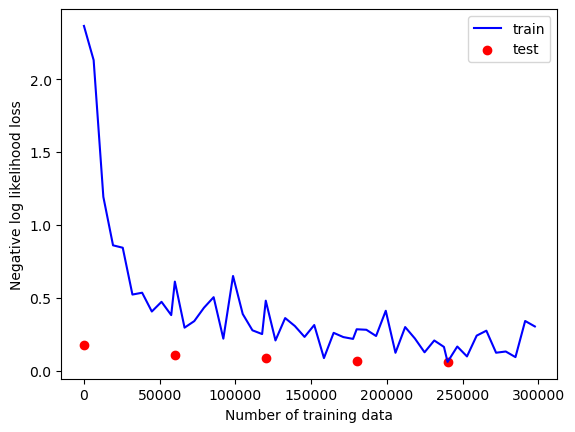

In [51]:
# 4-3. 学習開始

train(num_epochs=5)

# 正解率は97%程度
# 40,000ステップぐらいで収束している

## 5. 評価

テストデータの画像を変換して試してみる

/tmp/ipykernel_3278431/1494007758.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./model.pth"))


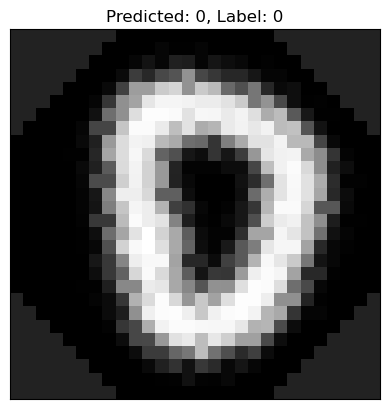

In [ ]:
# ランダムに画像を選び変形して予測

import random

def evaluate():
    # ランダムにデータを取得
    random_index = random.randint(0, len(test_dataset) - 1)
    data = test_dataset[random_index]

    # ガウシアンノイズを乗せて画像を回転する関数を作成
    augument_sample = torchvision.transforms.Compose([
        torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3)),
        torchvision.transforms.RandomRotation(degrees=(0, 60)),
    ]);


    # 画像を変換
    image_tensor = augument_sample(data[0])

    # モデルの推論様に前処理する関数を作成
    # 28x28にリサイズし、白黒に変換、正規化
    transform_sample = torchvision.transforms.Compose([
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.Normalize((test_scaled_mean,), (test_scaled_std,))
    ])

    # 関数を適用
    transformed = transform_sample(image_tensor)

    # モデルをロード（省略可能）
    # model = Net().to(device)
    # model.load_state_dict(torch.load("./model.pth"))

    # 評価モードに設定（勾配を計算しない）
    model.eval()

    # 推論しロジットを出力
    prediction = model(transformed.unsqueeze(0).to(device))

    # ノイズを乗せて回転された画像を表示
    image_numpy = image_tensor.squeeze().cpu().detach().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_numpy, cmap="gray")

    # 推論結果を表示
    plt.title(f"Predicted: {prediction.argmax().item()}, Label: {data[1]}")

evaluate()